<a href="https://colab.research.google.com/github/murasakiw/ML2/blob/main/A4_DL_TC5033_text_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Text Generation

<br>

#### Activity 4: Building a Simple LSTM Text Generator using WikiText-2
<br>

### Team 15
- Héctor Raúl Vázquez González - A00565542
- Ronald David Zuniga Sánchez - A01686240
- Sergio Omar Esparza Hernández - A01794338
- Hugo Enrique Solano Ortega - A01794456



Objective:
  - Gain a fundamental understanding of Long Short-Term Memory (LSTM) networks.
  - Develop hands-on experience with sequence data processing and text generation in PyTorch. Given the simplicity of the model, amount of data, and computer resources, the text you generate will not replace ChatGPT, and results must likely will not make a lot of sense. Its only purpose is academic and to understand the text generation using RNNs.
  - Enhance code comprehension and documentation skills by commenting on provided starter code.
    
<br>

Instructions:
  - Code Understanding: Begin by thoroughly reading and understanding the code. Comment each section/block of the provided code to demonstrate your understanding. For this, you are encouraged to add cells with experiments to improve your understanding

  - Model Overview: The starter code includes an LSTM model setup for sequence data processing. Familiarize yourself with the model architecture and its components. Once you are familiar with the provided model, feel free to change the model to experiment.

  - Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation.

  - Text Generation Function: Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

  - Code Commenting: Ensure that all the provided starter code is well-commented. Explain the purpose and functionality of each section, indicating your understanding.

  - Submission: Submit your Jupyter Notebook with all sections completed and commented. Include a markdown cell with the full names of all contributing team members at the beginning of the notebook.
    
<br>

- Evaluation Criteria:
    - Code Commenting (60%): The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.

    - Training Function Implementation (20%): The correct implementation of the training function, which should effectively train the model.

    - Text Generation Functionality (10%): A working function is provided in comments. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function.

    - Conclusions (10%): Provide some final remarks specifying the differences you notice between this model and the one used  for classification tasks. Also comment on changes you made to the model, hyperparameters, and any other information you consider relevant. Also, please provide 3 examples of generated texts.



# Code Setup and Data Preparation

**General imports**

- **numpy** and matplotlib.pyplot are libraries for numerical manipulation and data visualization in Python.
- **torch** is the primary framework for deep learning.
- **torchtext** is a PyTorch-specific library for processing textual data.
- **WikiText2** is a text dataset commonly used for natural language processing (NLP) tasks.
- random is used for generating random numbers
- **DataLoader** and **TensorDataset** are PyTorch classes for handling datasets and efficiently loading data during training.
- **random_split** is used to randomly split a dataset into training and testing sets.
- **get_tokenizer** is a function to obtain a tokenizer for processing text.
- **build_vocab_from_iterator** is used to build a vocabulary from a data iterator.
- **to_map_style_dataset** is a function to convert a dataset to the mapping style, necessary for efficient use with DataLoader.
- **nn** contains base classes for defining and training models in PyTorch.
- **F** contains activation and loss functions in PyTorch.
- **optim** contains optimizers, such as SGD or Adam, for adjusting model parameters during training.
- **tqdm** provides a progress bar during iterations.

In [ ]:
#General Data Wrangling Libraries
import numpy as np
import matplotlib.pyplot as plt
#PyTorch libraries
import torch
import torchtext
from torchtext.datasets import WikiText2
# Dataloader library
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import random

In [ ]:
#pip install portalocker>=2.0.0

checks if a CUDA-compatible GPU is available.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Define the device that will be used to train the model
print(device) #Print the device available

cuda


In this section, we define all the processing steps necessary to get the data in the proper format to feed the model. WikiText-2 Dataset consists of a collection of Wikipedia articles with over 100 million tokens that include words, subwords, and characters.

This line of code is using the **WikiText2** class from the torchtext.datasets module to load the WikiText-2 dataset and split it into three sets: training (**train_dataset**), validation (**val_dataset**), and testing (**test_dataset**).

In [ ]:
train_dataset, val_dataset, test_dataset = WikiText2() #Returns a datapipe that yields text from wikipedia articles

Basic english tokenizer is used to build a vocabulary setting rules for special tokens.

This code defines a tokenizer for processing English text using the **get_tokenizer** function from the torchtext.data.utils module. It also defines a generator function named **yield_tokens** that takes a collection of text data and yields the tokens produced by the tokenizer.

In [ ]:
#Using the tokeniser we can divide the text in tokens, convert lowercase and other transformations necessary to feed de model
#The basic_english parameter normalizes the string first and splits it by space
tokeniser = get_tokenizer('basic_english')
#The function takes the data set as parameter
#We ignore the label and we only need the text, which is passed to the tokeniser object
#'yield' allows to generate tokens one by one
def yield_tokens(data):
    for text in data:
        yield tokeniser(text)

This code is responsible for building a vocabulary from the training dataset using the tokenization function defined earlier. we create a vocab object which later will be used as an input parameter in the model embedding layer to create a lookup table to store word embeddings a retrieve them using indices. We specify the special symbols to add to the vocab object. Additionally, it sets up special tokens and assigns a default index to the unknown token ('<'unk'>')
Special tokens are defined as follows:
*  unk (unknown)
*  pad (padding)
*  bos (beginning of sequence)
*  eos (end of sequence).

In [ ]:
# Build the vocabulary
# Returns a vocab object, the function takes an iterator as first parameter which is the generator using the yield_tokens function
# specials define the special symbols to add
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In this subsection, the function 'data_process' is defined and then used to obtain all the inputs for the model. The resulting data consists of two tensors corresponding to inputs (x) and targets (y). The inputs (x) tensor consists of tensors with a sequence of indices representing the words in the raw text. The raw text is not completely converted to indices, the number of words considered is specified with the 'seq_length' parameter.

The function is defined to process raw text data into input-output pairs set for training.

The function tokenizes the text then converts the tokens to indices using the vocabulary, and creates sequences of a specified length.

The resulting data is then split into input (x) and target (y) tensors.

In [ ]:
seq_length = 50 #Number of elements considered for each text in the data set
def data_process(raw_text_iter, seq_length = 50):
    #Creates list with indices from tokeniser and then it is obtained as a tensor for each text in the torch datapipe
    data = [torch.tensor(vocab(tokeniser(item)), dtype=torch.long) for item in raw_text_iter]
    data = torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #remove empty tensors
#     target_data = torch.cat(d)
    return (data[:-(data.size(0)%seq_length)].view(-1, seq_length),
            data[1:-(data.size(0)%seq_length-1)].view(-1, seq_length)) #Returns the x input data and y target data

# Create tensors for the training set
x_train, y_train = data_process(train_dataset, seq_length) #Get the training data
x_val, y_val = data_process(val_dataset, seq_length) #Get the validation data
x_test, y_test = data_process(test_dataset, seq_length) #Get the test data

Tensors are created to prepare the dataset for training by converting the split Train, Val, and Test tokens.

In [ ]:
#The method TensorDataset wraps input and target datum and it is used to retrieve each sample by indexing tensors
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

Pytorch Dataloader is used to create the corresponding training, validation, and test dataset batches.

In [ ]:
batch_size = 64  # choose a batch size that fits your computation resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Model Preparation

The LSTM model is defined with a standard architecture consisting of an embedding layer, an LSTM layer, and a linear layer using a forward method to process the input sequences through the layers.

This code defines an LSTM (Long Short-Term Memory) model using PyTorch's nn.Module class. The model is designed for sequence-to-sequence tasks, such as language modeling.

- class LSTMModel(nn.Module):: This line defines a new class named LSTMModel, which inherits from nn.Module. This is a common practice when creating neural network models in PyTorch.

- def __init__(self, vocab_size, embed_size, hidden_size, num_layers):: The __init__ method is the constructor for the class. It initializes the parameters of the LSTM model.

- self.embeddings = nn.Embedding(vocab_size, embed_size): This line creates an embedding layer with input vocabulary size vocab_size and embedding size embed_size. Embedding layers are used to convert discrete tokens into continuous vector representations.

- self.hidden_size = hidden_size: Sets the hidden size of the LSTM.

- self.num_layers = num_layers: Sets the number of LSTM layers.

- self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True): Defines the LSTM layer. batch_first=True indicates that the input and output tensors should have the batch size as their first dimension.

- self.fc = nn.Linear(hidden_size, vocab_size): Defines a fully connected (linear) layer that maps the LSTM output to the vocabulary size. The FC layer is used to obtain all the probabilities on which word could be next in the sequence of words

- forward(self, text, hidden): This method defines the forward pass of the model. Given an input sequence text and the previous hidden state hidden, it computes the forward pass.

- embeddings = self.embeddings(text): Embeds the input sequence using the embedding layer.

- output, hidden = self.lstm(embeddings, hidden): Passes the embedded sequence through the LSTM layer, obtaining the output and the new hidden state.

- decoded = self.fc(output): Applies the fully connected layer to get the model's output.

- return decoded, hidden: Returns the output and the new hidden state.
- init_hidden(self, batch_size): This method initializes the hidden state of the LSTM. It returns a tuple representing the initial hidden state, consisting of zero tensors.



In [ ]:
# Define the LSTM model
# Feel free to experiment
class LSTMModel(nn.Module): #Define the class that will be used to build the model
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size #Number of neurons in the layer
        self.num_layers = num_layers #Number of hidden layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, #Input is the number of layers in the recurrent layer
                            vocab_size) #Output is the number of elements in the vocabulary

    def forward(self, text, hidden):
        embeddings = self.embeddings(text) #Obtain the indices for each word in the raw text
        output, hidden = self.lstm(embeddings, hidden) #Forward pass to obtain the outputs of the lstm layer
        decoded = self.fc(output) #FC to get all the probabilities on which word could be next
        return decoded, hidden

    def init_hidden(self, batch_size): #Method to initialize the first hidden state of the LSTM layer

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))



vocab_size = len(vocab) # vocabulary size
emb_size = 100 # embedding size
neurons = 128 # the dimension of the feedforward network model, i.e. # of neurons
num_layers = 5 # the number of nn.LSTM layers
model_1 = LSTMModel(vocab_size, emb_size, neurons, num_layers)
model_2 = LSTMModel(vocab_size, emb_size, neurons, num_layers)
num_layers_1 = 1
model_3 = LSTMModel(vocab_size, emb_size, neurons, num_layers_1)

This section contains a definition of a function to compute the accuracy of the model, the definition of a plot function to visualize training loss over each epoch and accuracy and a function to compute the perplexity metric.

This code defines a function named calculate_accuracy that computes the accuracy of a given PyTorch model on a specified data loader.
- def calculate_accuracy(model, data_loader):: This line defines a function named calculate_accuracy that takes a PyTorch model (model) and a data loader (data_loader) as input.

- model.eval(): Sets the model to evaluation mode. This is important when using layers like dropout, as it ensures they are not active during the evaluation.

- correct = 0 and total = 0: Initialize variables to keep track of the number of correctly predicted labels and the total number of labels.

- with torch.no_grad():: Temporarily disables gradient computation during the evaluation to save memory.

- for data, targets in data_loader:: Iterate over batches of data and corresponding targets in the provided data loader.

- xi = data.to(device=device, dtype=torch.long): Move the input data to the specified device (GPU or CPU) and set its data type.

- yi = targets.to(device=device, dtype=torch.long): Move the target labels to the specified device and set their data type.

- hidden = model.init_hidden(batch_size=data.size(0)): Initialize the hidden state of the model based on the batch size of the current data.

- scores, hidden = model(xi, hidden): Get model predictions (scores) and the updated hidden state for the input data.

- predicted_labels = torch.argmax(scores, dim=2): Predict the labels by selecting the index with the maximum score along the second dimension (assuming the output is a sequence).

- correct += (predicted_labels == yi).sum().item(): Count the number of correctly predicted labels.

- total += yi.numel(): Update the total count of labels.

- accuracy = correct / total: Calculate the accuracy as the ratio of correctly predicted labels to the total number of labels.

- return accuracy: Return the calculated accuracy.

In [ ]:
def calculate_accuracy(model, data_loader):
    model.eval() #Set model to evaluation mode
    correct = 0 #Variable to store the number of correct predictions
    total = 0 #Variable to store the number of total samples
    with torch.no_grad():
        for data, targets in data_loader: #Loop through the data loader to obtain mini batches
            xi = data.to(device=device, dtype=torch.long) #Input data as torch tensors using GPU
            yi = targets.to(device=device, dtype=torch.long) #Targets as torch tensors using GPU

            hidden = model.init_hidden(batch_size=data.size(0))
            scores, hidden = model(xi, hidden) #Obtain the ouputs of the model
            predicted_labels = torch.argmax(scores, dim=2)
            correct += (predicted_labels == yi).sum().item() #Sum the total of correct samples
            total += yi.numel() #Obtain the total samples of the batch and add the result to the variable

    accuracy = correct / total #Calculate the accuracy
    return accuracy

This code defines a function named plot_loss that takes a list of training losses as input and generates a simple line plot to visualize the training loss over epochs.

- def plot_loss(train_losses):: This line defines a function named plot_loss that takes a list of training losses (train_losses) as an argument.

- plt.plot(train_losses, label='Training Loss'): Plots the training losses using the plot function from the matplotlib.pyplot library. The label parameter is set to 'Training Loss' for the legend.

- plt.xlabel('Epochs'): Adds a label to the x-axis of the plot, indicating the number of epochs.

- plt.ylabel('Loss'): Adds a label to the y-axis of the plot, indicating the loss value.

- plt.title('Training Loss Over Epochs'): Adds a title to the plot.

- plt.legend(): Displays the legend on the plot, utilizing the label provided in the plot function.

- plt.show(): Finally, displays the plot.

In [ ]:
def plot_loss(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

This code defines a function named plot_accuracy that takes a list of validation accuracies as input and generates a line plot to visualize how the validation accuracy changes over epochs

- def plot_accuracy(val_accuracies):: This line defines a function named plot_accuracy that takes a list of validation accuracies (val_accuracies) as an argument.

- plt.plot(val_accuracies, label='Validation Accuracy', color='green'): Plots the validation accuracies using the plot function from the matplotlib.pyplot library. The label parameter is set to 'Validation Accuracy' for the legend, and the color parameter is set to 'green'.

- plt.xlabel('Epochs'): Adds a label to the x-axis of the plot, indicating the number of epochs.

- plt.ylabel('Accuracy'): Adds a label to the y-axis of the plot, indicating the accuracy value.

- plt.title('Validation Accuracy Over Epochs'): Adds a title to the plot.

- plt.legend(): Displays the legend on the plot, utilizing the label provided in the plot function.

- plt.tight_layout(): Adjusts the layout of the plot for better appearance.

- plt.show(): Finally, displays the plot.

In [ ]:
def plot_accuracy(val_accuracies):
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

This code defines a training function named train for a PyTorch model. It performs training over a specified number of epochs, calculating the loss and accuracy during each epoch.

In [ ]:

def train(model, epochs, optimiser):
    train_losses=list() #Define list to store the training losses
    val_accuracies = list() #Define list to store the validation accuracies
    train_accuracies = list()
    model = model.to(device=device) #Set the device to use GPU
    total_cost = 0
    val_cost = 0

    for epoch in range(epochs):
        total_cost = 0
        total_perplexity = 0 #Variable to store the total perplexity metric of the model
        model.train()
        for data, targets in train_loader:
            # TO COMPLETE
            xi = data.to(device=device, dtype = torch.long) #Input data as torch tensors using GPU
            yi = targets.to(device=device, dtype = torch.long) #Labels / tokens as torch tensors using GPU
            hidden = model.init_hidden(batch_size=data.size(0))
            optimiser.zero_grad()
            scores, hidden = model(xi, hidden) #Obtain the ouput of the model
            scores_reshaped = scores.permute(0,2,1) #Obtain the ouput of the model
            cost = F.cross_entropy(scores_reshaped, yi) #Apply the cross_entropy function to calculate the cost
            perplexity = torch.exp(cost)
            cost.backward() #Calculate gradients with respect to all parameters of the model
            optimiser.step() #Update parameters considering the defined optimiser
            total_cost+=cost.item()
            total_perplexity+=perplexity

        #Obtain the training and validation accuracies
        average_cost = total_cost/len(train_loader) #Calculate average cost
        average_pp = total_perplexity/len(train_loader) #Calculate average perplexity
        #Record list of training losses
        train_losses.append(average_cost)

        # Calculate model accuracy
        val_accuracy = calculate_accuracy(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch: {epoch} --- Average cost: {average_cost: .4f} --- Val. Accuracy: {val_accuracy * 100:.2f}% --- Average perplexity: {average_pp: .4f}')
    return val_accuracies, train_losses

# Model Training

This code calls the train function to train the previously defined PyTorch model

Epoch: 0 --- Average cost:  7.1557 --- Val. Accuracy: 6.86% --- Average perplexity:  1407.7208
Epoch: 1 --- Average cost:  6.9998 --- Val. Accuracy: 6.84% --- Average perplexity:  1098.7128
Epoch: 2 --- Average cost:  6.5308 --- Val. Accuracy: 16.72% --- Average perplexity:  713.5651
Epoch: 3 --- Average cost:  5.8831 --- Val. Accuracy: 19.96% --- Average perplexity:  361.1914
Epoch: 4 --- Average cost:  5.5993 --- Val. Accuracy: 21.06% --- Average perplexity:  270.9960
Epoch: 5 --- Average cost:  5.4182 --- Val. Accuracy: 21.46% --- Average perplexity:  226.0522
Epoch: 6 --- Average cost:  5.2751 --- Val. Accuracy: 21.48% --- Average perplexity:  195.9606
Epoch: 7 --- Average cost:  5.1535 --- Val. Accuracy: 21.81% --- Average perplexity:  173.5490
Epoch: 8 --- Average cost:  5.0506 --- Val. Accuracy: 21.91% --- Average perplexity:  156.5704
Epoch: 9 --- Average cost:  4.9604 --- Val. Accuracy: 21.98% --- Average perplexity:  143.0672
Epoch: 10 --- Average cost:  4.8788 --- Val. Accur

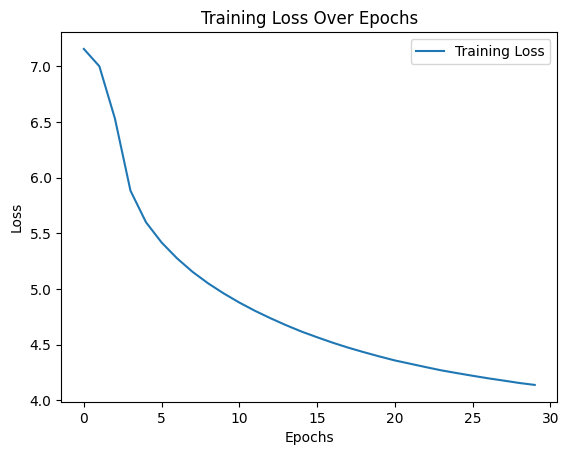

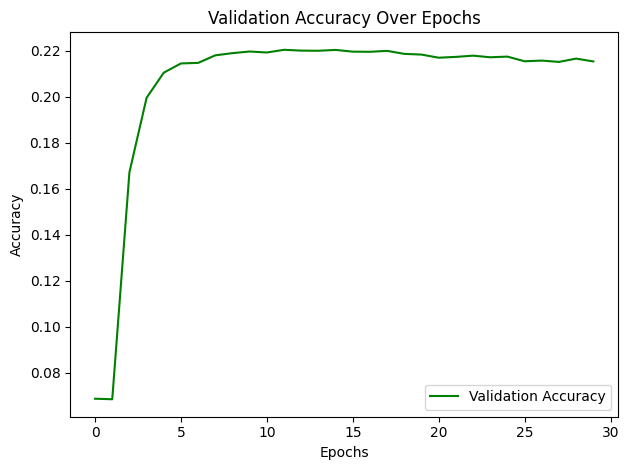

In [ ]:
# Call the training function using the model with 5 hidden layers and lr=0.005
loss_function = nn.CrossEntropyLoss()
lr = 0.005
epochs = 30
optimiser = optim.Adam(model_1.parameters(), lr=lr)
val_accuracies, train_losses = train(model_1, epochs, optimiser)
# Plot Losses
plot_loss(train_losses)
# Plot accuracies
plot_accuracy(val_accuracies)

Epoch: 0 --- Average cost:  7.1182 --- Val. Accuracy: 6.84% --- Average perplexity:  1932.8848
Epoch: 1 --- Average cost:  6.9343 --- Val. Accuracy: 6.86% --- Average perplexity:  1028.1733
Epoch: 2 --- Average cost:  6.9301 --- Val. Accuracy: 6.86% --- Average perplexity:  1023.7622
Epoch: 3 --- Average cost:  6.9256 --- Val. Accuracy: 6.86% --- Average perplexity:  1019.1217
Epoch: 4 --- Average cost:  6.9223 --- Val. Accuracy: 6.86% --- Average perplexity:  1015.7511
Epoch: 5 --- Average cost:  6.9198 --- Val. Accuracy: 6.86% --- Average perplexity:  1013.2856
Epoch: 6 --- Average cost:  6.9070 --- Val. Accuracy: 8.97% --- Average perplexity:  1000.7856
Epoch: 7 --- Average cost:  6.5185 --- Val. Accuracy: 14.78% --- Average perplexity:  684.1314
Epoch: 8 --- Average cost:  6.2020 --- Val. Accuracy: 16.87% --- Average perplexity:  495.4293
Epoch: 9 --- Average cost:  6.0247 --- Val. Accuracy: 17.64% --- Average perplexity:  414.5253
Epoch: 10 --- Average cost:  5.9085 --- Val. Accur

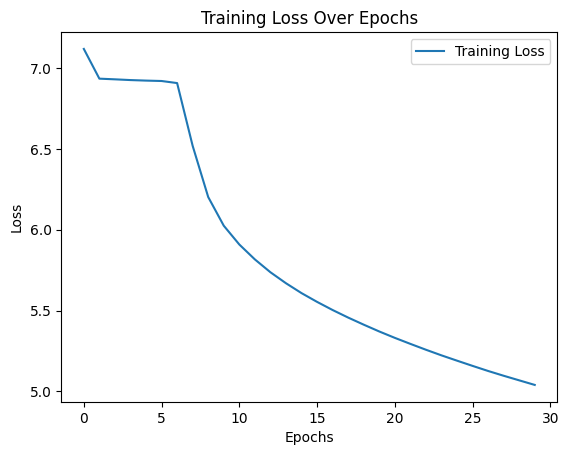

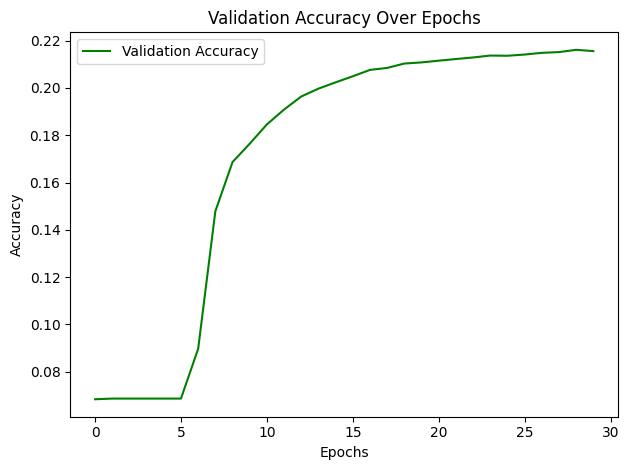

In [ ]:
# Call the training function using the model with 5 hidden layers and lr=0.0005
loss_function = nn.CrossEntropyLoss()
lr = 0.0005
epochs = 30
optimiser = optim.Adam(model_2.parameters(), lr=lr)
val_accuracies, train_losses = train(model_2, epochs, optimiser)
# Plot Losses
plot_loss(train_losses)
# Plot accuracies
plot_accuracy(val_accuracies)

Epoch: 0 --- Average cost:  7.0495 --- Val. Accuracy: 13.02% --- Average perplexity:  2209.8640
Epoch: 1 --- Average cost:  6.4355 --- Val. Accuracy: 14.84% --- Average perplexity:  626.3947
Epoch: 2 --- Average cost:  6.1979 --- Val. Accuracy: 16.75% --- Average perplexity:  493.2673
Epoch: 3 --- Average cost:  6.0288 --- Val. Accuracy: 17.74% --- Average perplexity:  416.2675
Epoch: 4 --- Average cost:  5.9044 --- Val. Accuracy: 18.43% --- Average perplexity:  367.5024
Epoch: 5 --- Average cost:  5.8041 --- Val. Accuracy: 19.07% --- Average perplexity:  332.3984
Epoch: 6 --- Average cost:  5.7189 --- Val. Accuracy: 19.51% --- Average perplexity:  305.2534
Epoch: 7 --- Average cost:  5.6439 --- Val. Accuracy: 20.00% --- Average perplexity:  283.1898
Epoch: 8 --- Average cost:  5.5773 --- Val. Accuracy: 20.36% --- Average perplexity:  264.9582
Epoch: 9 --- Average cost:  5.5169 --- Val. Accuracy: 20.63% --- Average perplexity:  249.4149
Epoch: 10 --- Average cost:  5.4615 --- Val. Accu

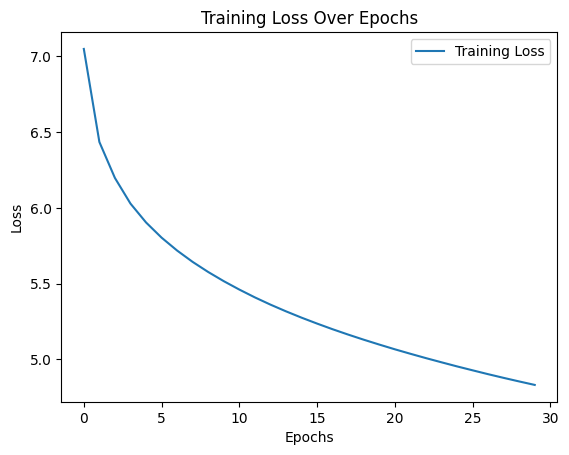

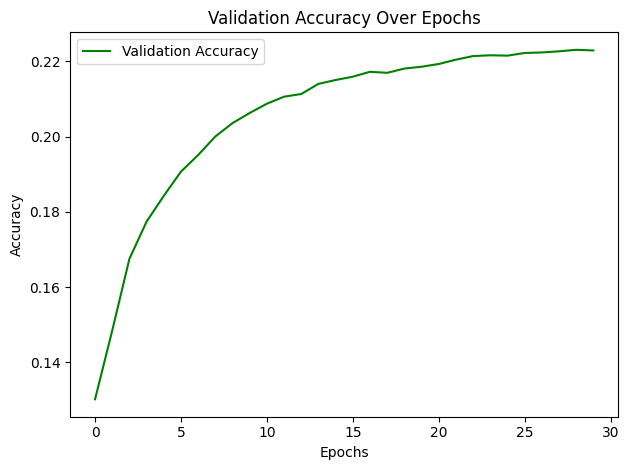

In [ ]:
# Call the training function using the model with 1 hidden layer and lr=0.0005
loss_function = nn.CrossEntropyLoss()
lr = 0.0005
epochs = 30
optimiser = optim.Adam(model_3.parameters(), lr=lr)
val_accuracies, train_losses = train(model_3, epochs, optimiser)
# Plot Losses
plot_loss(train_losses)
# Plot accuracies
plot_accuracy(val_accuracies)

Although we define a function to compute the accuracy of the model, we consider that this metric is not optimum for this type of problem, because it is not a classification problem, but we computed it just to see how this metric behaves with this problem. For this type of problem we can compute the perplexity metric which is a measure of how well the model predicts a sequence. The disadvantage of this metric is that it has to be compared with other models or other configurations to get an idea of how good is the model predicting the next word in the sequence. So, in order to visualize if the model is improving with every epoch, we computed also the perplexity and we can see how this value decreases with every epoch. We plotted the accuracy values just to see how it behaves in order to compare the use of this metric with the classification model used in a previous activity. By looking at the accuracies plot we can conclude that this metric is not very useful for text generation cases.

# Model Evaluation

In order to compare the performance of the model with new data, we defined a function to compute the perplexity metric using the test data set. In this case it is only necessary to apply the 'torch.exp' function to the cost value to obtain the perplexity value. This function is very similar to the ones that we utilized previously in other activities, but in this case it is necessary to rearrange the way the elements are organized in order to apply the cross entropy function to the model outputs.

In [ ]:
def calculate_perplexity(model, data_loader):
    model.eval() #Set model to evaluation mode
    model = model.to(device=device) #Set the device to GPU
    perplexity_results = list() #Define list to store perplexity values
    with torch.no_grad():
        for data, targets in data_loader: #Loop through the data loader to obtain mini batches
            xi = data.to(device=device, dtype = torch.long) #Input data as torch tensors using GPU
            yi = targets.to(device=device, dtype = torch.long) #Targets as torch tensors using GPU
            hidden = model.init_hidden(batch_size=data.size(0)) #Initialize first hidden state
            scores, hidden = model(xi, hidden) #Obtain model outputs
            scores_reshaped = scores.permute(0,2,1) #Rearrange elements to compute cross_entropy
            cost = F.cross_entropy(scores_reshaped, yi)
            perplexity = torch.exp(cost) #Compute perplexity using cost value
            perplexity_results.append(perplexity) #Append perplexity values
    average_perplexity = sum(perplexity_results)/len(perplexity_results)
    print(f'The average perplexity for the test data set: {average_perplexity}') #Print perplexity of the data set

In [ ]:
#Print average perplexity for model with 5 neurons and lr=0.005
calculate_perplexity(model_1, test_loader)

The average perplexity for the test data set: 402.248779296875


In [ ]:
#Print average perplexity for model with 5 neurons and lr=0.0005
calculate_perplexity(model_2, test_loader)

The average perplexity for the test data set: 211.52268981933594


In [ ]:
#Print average perplexity for model with 1 neuron and lr=0.0005
calculate_perplexity(model_3, test_loader)

The average perplexity for the test data set: 196.14646911621094


We noticed by looking at the perplexity values using the test data set that there is an important degree of overfitting present in the model, so in order to get a better performance, this problem should be attended.

---

This code defines a function named generate_text that uses a trained language model to generate a sequence of words given a starting text. It uses a technique called "sampling" to probabilistically select the next word based on the model's predictions.

- model.eval(): Puts the model in evaluation mode. This is important because some layers, like dropout, behave differently during training and evaluation.

- words = tokeniser(start_text): Tokenizes the starting text into a list of words using the tokenizer defined earlier.

- hidden = model.init_hidden(1): Initializes the hidden state of the model for generating text. The batch size is set to 1.

The function then enters a loop to generate the specified number of words:

- x = torch.tensor([[vocab[word] for word in words[i:]]], dtype=torch.long, device=device): Converts a subsequence of words into a tensor of indices using the vocabulary.

- y_pred, hidden = model(x, hidden): Uses the model to predict the next word given the input sequence.

- last_word_logits = y_pred[0][-1]: Retrieves the logits (raw scores) for the last word in the predicted sequence.

- p = (F.softmax(last_word_logits / temperature, dim=0).detach()).to(device='cpu').numpy(): Applies temperature to the logits to control the randomness of the sampling. Then, it converts the logits to probabilities and detaches the computation graph to prevent backpropagation during sampling.

- word_index = np.random.choice(len(last_word_logits), p=p): Samples the next word index based on the probabilities.

- words.append(vocab.lookup_token(word_index)): Appends the newly generated word to the list of words.

Finally, the function returns the generated text by joining the list of words.

- print(generate_text(model, start_text="I found a", num_words=10)): Calls the generate_text function with a starting text and prints the generated sequence of words. The num_words parameter controls the length of the generated text.

To test the model we used the model that had a better performance with the test data set, because in the parameters of the function that generates text it is possible to enter a text that is not related to the texts that were used to train the model. So, to generate the text we used the model with 5 hidden layers and a learning rate of 0.0005, because it is the one that presented the smallest difference between perplexity values for training and testing.

In [ ]:
def generate_text(model, start_text, num_words, temperature=1.0):

    model.eval()
    words = tokeniser(start_text)
    hidden = model.init_hidden(1)
    for i in range(0, num_words):
        x = torch.tensor([[vocab[word] for word in words[i:]]], dtype=torch.long, device=device)
        y_pred, hidden = model(x, hidden)
        last_word_logits = y_pred[0][-1]
        p = (F.softmax(last_word_logits / temperature, dim=0).detach()).to(device='cpu').numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(vocab.lookup_token(word_index))

    return ' '.join(words)

# Generate some text
print(generate_text(model_2, start_text="I found a", num_words=20))


i found a early neutral charge . small singer <unk> graham @-@ chris who recorded the guitar pop series in all a game


In [ ]:
# Generate some text
print(generate_text(model_2, start_text="I am in love with", num_words=20))

i am in love with neck . gielgud was aimed in brentford to be being replaced by his <unk> . in the video ball ,


In [ ]:
# Generate some text
print(generate_text(model_2, start_text="Deep learning is", num_words=20))

deep learning is displayed in various status such as secondary processes and <unk> , black , julien long , <unk> . = =


In [ ]:
# Generate some text
print(generate_text(model_2, start_text="Super Mario Land", num_words=20))

super mario land outweighed their opposition to her full @-@ open conversion that contained now a hip states @-@ five <unk> up in


# Conclusions

What we learn:
- The number of LSTM Layers: we need to start with small number of layers (1 or 2) and increase your way up. Althouhg increasing the number of layers may capture more complex patterns, it requires more time and computational power. It may not be needed.
- The size of the batch: THe larger the batch, the faster it converges. But it will require more memory and computational power as well.
- Number of Epochs: The number of epochs deternime how many times the model goes through the entire trainig dataset. We need to monitor the performance curver (training and validation) in order to get the best model's performance.
- In this case, the Temperature: this parameter will control the randomness of the generated text. The bigger the more "diverse", but may result in a non coherent text. Lower values produce a more "focused" text.
- Learning Rate: As always is a very important parameter. A general good starting point will be in the range of  0.001 to 0.01. And as Always, experimenting with it is recommended to increase the performance of the model.

In this notebook, we compared three models: one with 5 hidden layers in the LSTM layer, another with only 1 layer in the LSTM, and a third identical to the 5 hidden layers model but with a larger learning rate. We conducted this comparison to test the performance of these models using the perplexity metric. Comparing the generated texts proved challenging as they did not make much sense.

When comparing models with different learning rates, we observed that using a lower learning rate resulted in better performance with the test set. Despite the perplexity metric and cost being lower during training, a lower learning rate helps avoid local minima, allowing the model to generalize better for new data.

In the comparison of models with different numbers of hidden layers in the LSTM layer, we noticed that the model with more hidden layers took longer to train but performed better with the test set. Although complexity increased, the training time did not escalate significantly. Therefore, increasing the number of hidden layers appears to be a beneficial solution for enhancing the model's performance and generalization.

One of the main differences between this model and the one used for the classification task of different news is that the accuracy metric is no longer useful. This is because the model's output is a vector representing the probability that a word appears after another word. Consequently, in this notebook, we proposed the perplexity metric to measure the model's performance and ensure that training improves its ability to predict subsequent words.

Ultimately, the perplexity metric helped us verify the model's improvement with each training epoch, as evidenced by the decreasing perplexity value. It also enabled us to compare models and identify which one had the best performance.
